# Depurando los datos

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
covid_aragon = pd.read_csv('covid_aragon.csv')

In [3]:
covid_aragon

,Unnamed: 0,FECHA,AFECTADOS,MUERTOS,UCI,Altas,PCR,Req Hospital
0,0,5/3/20,1.0,0,1,0.0,1,NaN
1,1,6/3/20,6.0,1,1,0.0,6,NaN
2,2,9/3/20,13.0,1,1,0.0,13,NaN
3,3,10/3/20,38.0,3,3,0.0,38,NaN
4,4,11/3/20,45.0,4,3,0.0,45,NaN
...,...,...,...,...,...,...,...,...
320,320,21/1/21,NaN,2808,958,NaN,91191,10608.0
321,321,22/1/21,NaN,2824,960,NaN,91963,10692.0
322,322,23/1/21,NaN,2835,968,NaN,92643,10769.0
323,323,24/1/21,NaN,2847,977,NaN,93324,10847.0


In [4]:
covid_aragon["FECHA"] = pd.to_datetime(covid_aragon["FECHA"], dayfirst=True)

In [5]:
pcr_series = covid_aragon[["FECHA", "PCR"]]

Detección de valores incorrectos:

In [42]:
iarr = np.where(np.diff(pcr_series["PCR"]) < 0)[0]
iarr = np.array(sorted(set([i for i in iarr] + [i+1 for i in iarr] + [i-1 for i in iarr])))
pcr_series.iloc[iarr]

,FECHA,PCR
38,2020-04-14,4338
39,2020-04-15,4566
40,2020-04-16,4558
41,2020-04-17,4551
76,2020-05-22,5627
77,2020-05-23,5646
78,2020-05-24,5623
79,2020-05-25,5600


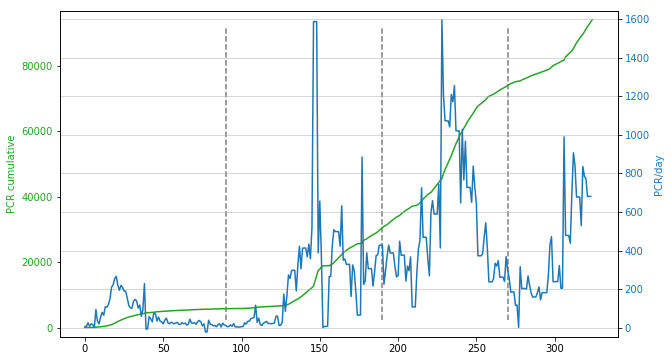

In [91]:
estimated_cuts = [0, 90, 190, 270, 325]

fig, ax1 = plt.subplots(figsize=(10,6))

for cut in estimated_cuts[1:-1]:
    ax1.axvline(cut, ymin=0.05, ymax=0.95, ls='--', c='grey')

    
m1 = np.max(pcr_series["PCR"])
m2 = np.max(np.diff(pcr_series["PCR"]))

color = 'tab:green'
ax1.plot(pcr_series["PCR"], color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylabel("PCR cumulative", color=color)

ax1.set_ylim([-m1*0.03, m1*1.03])

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.plot(np.diff(pcr_series["PCR"]), color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylabel("PCR/day", color=color)
ax2.set_ylim([-m2*0.03, m2*1.03])

plt.grid(linewidth=.5)

plt.savefig("pcr_series.png", dpi=300)

plt.show()

In [71]:
pcr_series["FECHA"].iloc[[90, 190, 270]]

90    2020-06-05
190   2020-09-13
270   2020-12-02
Name: FECHA, dtype: datetime64[ns]

In [7]:
olas = []
for i in range(len(estimated_cuts)-1):
    olas.append(pcr_series[estimated_cuts[i]:estimated_cuts[i+1]])

In [8]:
covid1 = olas[0]
covid2 = olas[1]

In [9]:
covid1[-1:]

,FECHA,PCR
89,2020-06-04,5757


In [10]:
covid2[0:1]

,FECHA,PCR
90,2020-06-05,5770


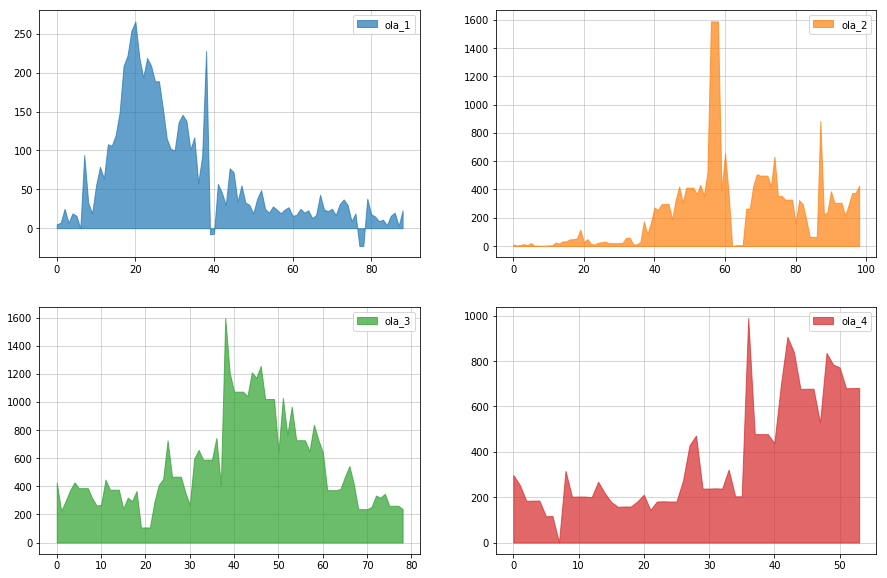

In [97]:
fig, axs = plt.subplots(2, 2, figsize=[15, 10])

colors = ["C0", "C1", "C2", "C3"]

for i in range(4):
    ax = axs[i//2, i % 2]
    x = np.arange(len(olas[i]["PCR"])-1)
    ax.fill_between(x, np.diff(olas[i]["PCR"]),
                    alpha=0.7,
                    label="ola_%d"%(i+1),
                    color=colors[i])
    ax.set_axisbelow(True)
    ax.grid(alpha=0.5, linewidth=1)
    ax.legend()

plt.savefig("pcr_olas.png", dpi=300)
plt.show()  

In [12]:
for i in range(len(estimated_cuts)-1):
    olas[i].to_csv("covid_aragon_ola_%d" % (i + 1))